# Импорт библиотек

In [30]:
import os
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [31]:
CT_DIR = './RESULT'
TIE_LOG = 'tie_log.txt'
REC_LOG = 'reciprocity_log.txt'

## 2. Парсинг CT-файлов <a id="parsing"></a>
Функция `parse_ct` читает CT-файл и возвращает словарь: позиция -> партнёр.

In [32]:
def parse_ct(filepath):
    partners = {}
    nts = {}
    with open(filepath, 'r') as f:
        header = f.readline().split()
        L = int(header[0])
        for _ in range(L):
            parts = f.readline().strip().split()
            i = int(parts[0])
            nt = parts[1]
            j = int(parts[4])
            partners[i] = j
            nts[i] = nt
    return partners, nts

files = [os.path.join(CT_DIR, f) for f in os.listdir(CT_DIR) if f.endswith('.ct')]
models = {}
model_nts = {}
for fn in files:
    name = os.path.splitext(os.path.basename(fn))[0]
    p, n = parse_ct(fn)
    models[name] = p
    model_nts[name] = n

positions = sorted(models[next(iter(models))].keys())
# последовательность из первой модели
consensus_seq = ''.join(model_nts[next(iter(model_nts))][i] for i in positions)


## 3. Сбор в DataFrame <a id="build_df"></a>
Создаём DataFrame: строки — позиции, столбцы — модели, значения — партнёры.

In [33]:
df = pd.DataFrame({name: pd.Series(p) for name, p in models.items()})
df.index.name = 'Position'
display(df.head(93))


CTE_human_CONTRAfold  CTE_human_LinearFold_c  \
Position                                                 
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   
5                           93                      93   
...                        ...                     ...   
89                           9                       9   
90                           8                       8   
91                           7                       7   
92                           6                       6   
93                           5                       5   

          CTE_human_LinearFold_v  CTE_human_RNAfold_C  CTE_human_RNAfold_M  \
Position                                                                     
1                              0                    0                    0   
2                              0                    0                    0   
3                              0                    0                    0   
4                              0                    0                    0   
5                             93                   93                   93   
...                          ...                  ...                  ...   
89                             9                    9                    9   
90                             8                    8                    8   
91                             7                    7                    7   
92                             6                    6                    6   
93                             5                    5                    5   

          CTE_human_RNAstructure_MaxExpect  CTE_human_RNAstructure_MFE  \
Position                                                                 
1                                        0                           0   
2                                        0                           0   
3                                        0                           0   
4                                        0                           0   
5                                       93                          93   
...                                    ...                         ...   
89                                       9                           9   
90                                       8                           8   
91                                       7                           7   
92                                       6                           6   
93                                       5                           5   

          CTE_human_RNAstructure_partition  CTE_human_RNAstructure_ProbKnot  \
Position                                                                      
1                                        0                                0   
2                                        0                                0   
3                                        0                                0   
4                                        0                                0   
5                                       93                               93   
...                                    ...                              ...   
89                                       9                                9   
90                                       8                                8   
91                                       7                                7   
92                                       6                                6   
93                                       5                                5   

          CTE_human_RNAstructure_suboptimal  CTE_human_RNA_e2efold  \
Position                                                             
1                                         0                     93   
2                                      

## 4. Выбор консенсусного партнёра <a id="consensus"></a>
Для каждой позиции:
- Находим самый частый партнёр (mode).
- Если несколько партнёров с одинаковой частотой — ставим 0 и логируем.

In [34]:
consensus = {}
ties = []
for pos in positions:
    cnt = Counter(df.loc[pos])
    m = max(cnt.values())
    modes = [x for x, c in cnt.items() if c == m]
    consensus[pos] = modes[0] if len(modes) == 1 else 0
    if len(modes) > 1:
        ties.append((pos, modes, dict(cnt)))
print("Tie positions:", len(ties))


Tie positions: 2


## 5. Проверка взаимности консенсусных пар <a id="reciprocity"></a>
Убеждаемся, что если для i → j, то и j → i. Иначе — обе позиции в 0 и логируем.

In [35]:
breaks = []
for i, j in list(consensus.items()):
    if j and consensus.get(j, 0) != i:
        breaks.append((i, j, consensus.get(j, 0)))
        consensus[i] = consensus[j] = 0
print("Reciprocity breaks:", len(breaks))


Reciprocity breaks: 3


## 6. Сохранение результатов <a id="saving"></a>
- `consensus_structure.csv`: таблица позиция → партнёр
- `consensus.ct`: CT-файл с консенсусом
- `consensus.dot`: dot-bracket нотация
- Логи: `tie_log.txt`, `reciprocity_log.txt`

In [36]:
# 6.1 consensus_structure.csv
pd.DataFrame.from_dict(consensus, orient='index', columns=['Partner']) \
  .rename_axis('Position').to_csv('consensus_structure.csv')

# 6.2 consensus.ct
with open('consensus.ct', 'w') as f:
    f.write(f"{len(positions)} Consensus structure\n")
    for idx, pos in enumerate(positions, 1):
        nt = consensus_seq[idx-1]
        pr = consensus[pos]
        prev_p = idx-1 if idx>1 else 0
        next_p = idx+1 if idx<len(positions) else 0
        f.write(f"{idx} {nt} {prev_p} {next_p} {pr} {idx}\n")

# 6.3 consensus.dot
dot = ['.'] * len(positions)
for i, j in consensus.items():
    if j > i:
        dot[i-1], dot[j-1] = '(', ')'
with open('consensus.dot', 'w') as f:
    f.write(consensus_seq + "\n")
    f.write("".join(dot))

# 6.4 scores.csv
scores = []
for name, part in models.items():
    match = sum(1 for pos in positions if part[pos] == consensus[pos])
    pct = match / len(positions) * 100
    scores.append({'Model': name, 'Agreement (%)': pct})
scores_df = pd.DataFrame(scores).sort_values('Agreement (%)', ascending=False)
from IPython.display import display
display(scores_df)
scores_df.to_csv('scores.csv', index=False)

# 6.5 логи
with open(TIE_LOG, 'w') as f:
    for t in ties:
        f.write(f"{t}\n")
with open(REC_LOG, 'w') as f:
    for b in breaks:
        f.write(f"{b}\n")


Model  Agreement (%)
3                 CTE_human_RNAfold_C      93.548387
14    CTE_human__RNALinearPartition_T      89.247312
4                 CTE_human_RNAfold_M      87.096774
13    CTE_human_RNA_LinearPartition_M      87.096774
9   CTE_human_RNAstructure_suboptimal      84.946237
6          CTE_human_RNAstructure_MFE      84.946237
2              CTE_human_LinearFold_v      84.946237
7    CTE_human_RNAstructure_partition      75.268817
0                CTE_human_CONTRAfold      70.967742
8     CTE_human_RNAstructure_ProbKnot      67.741935
11  CTE_human_RNA_ERNIE-RNA_fine_tune      60.215054
5    CTE_human_RNAstructure_MaxExpect      59.139785
12   CTE_human_RNA_ERNIE-RNA_pretrain      47.311828
1              CTE_human_LinearFold_c      45.161290
10              CTE_human_RNA_e2efold      43.010753

## 7. Сравнение моделей с консенсусом <a id="comparison"></a>
Вычисляем процент позиций, где модель совпадает с консенсусом.

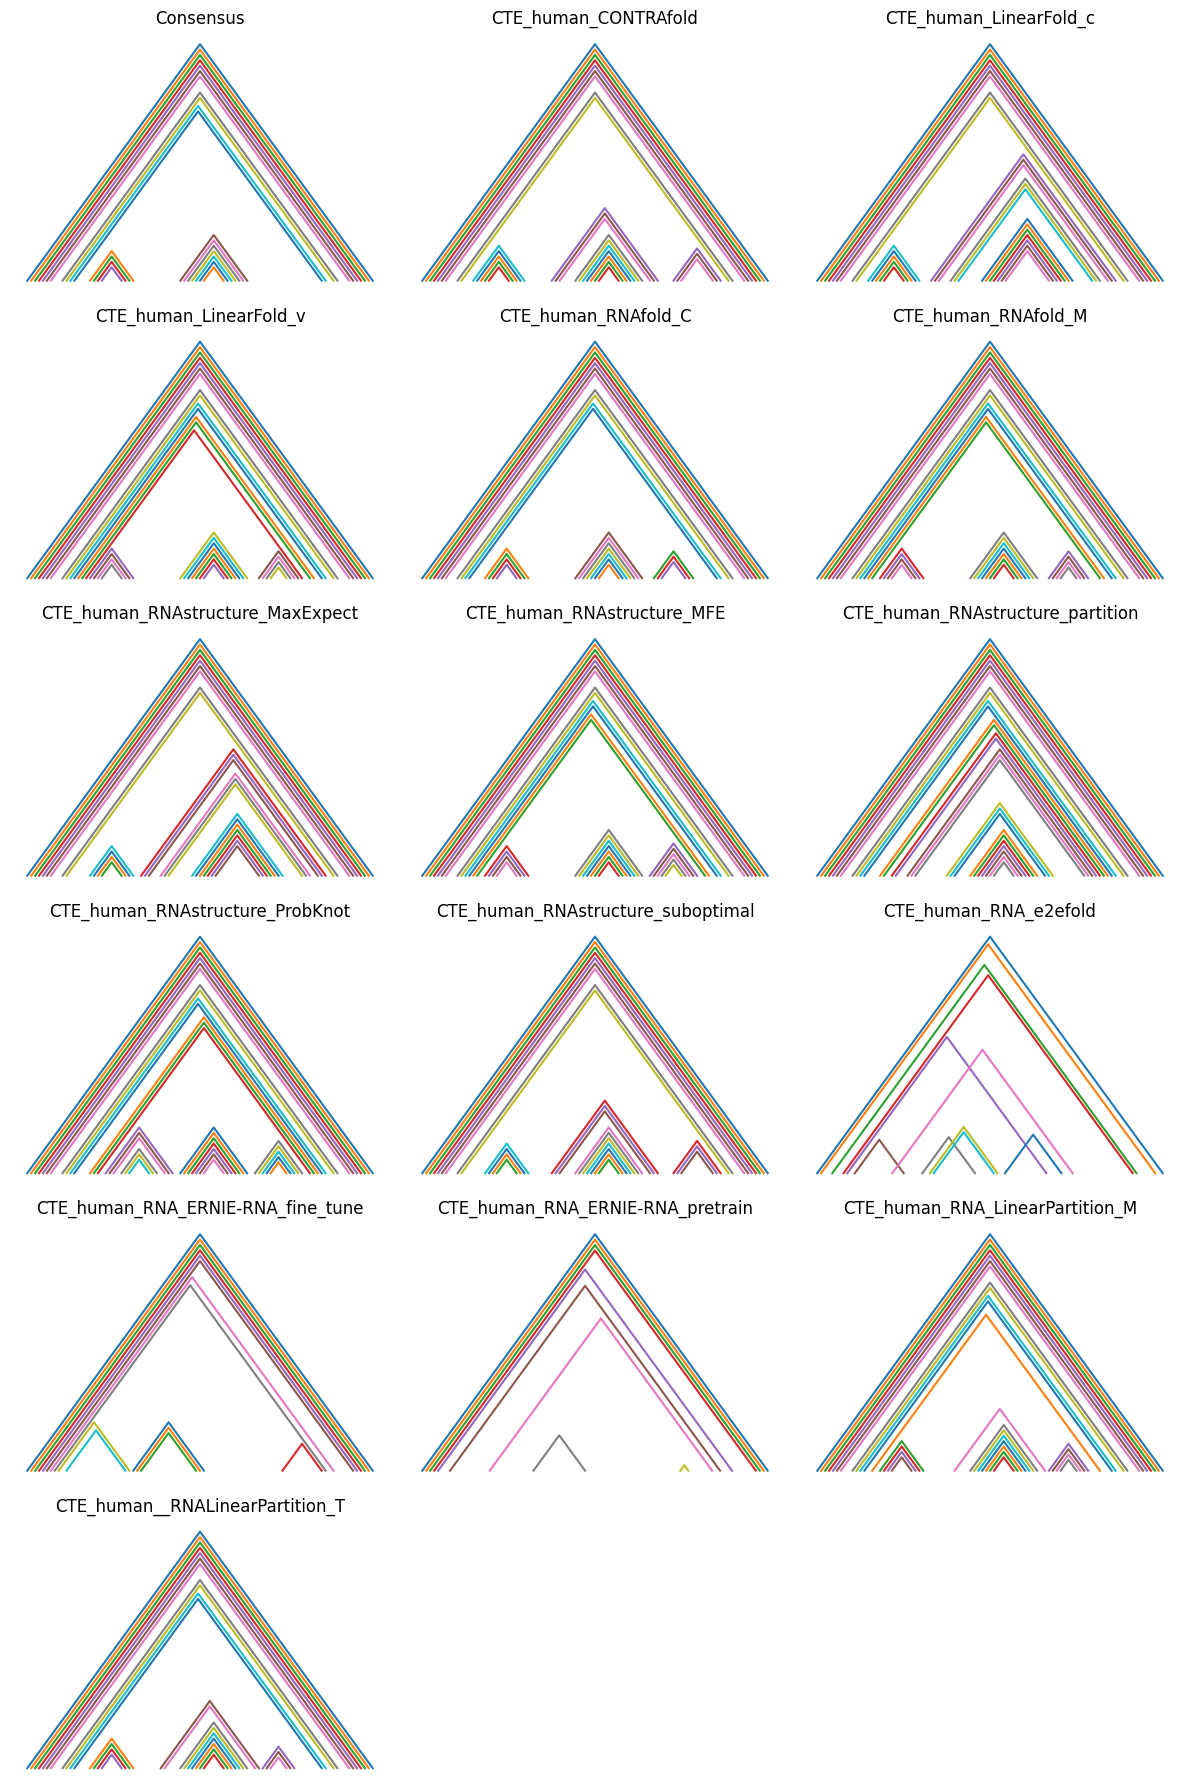

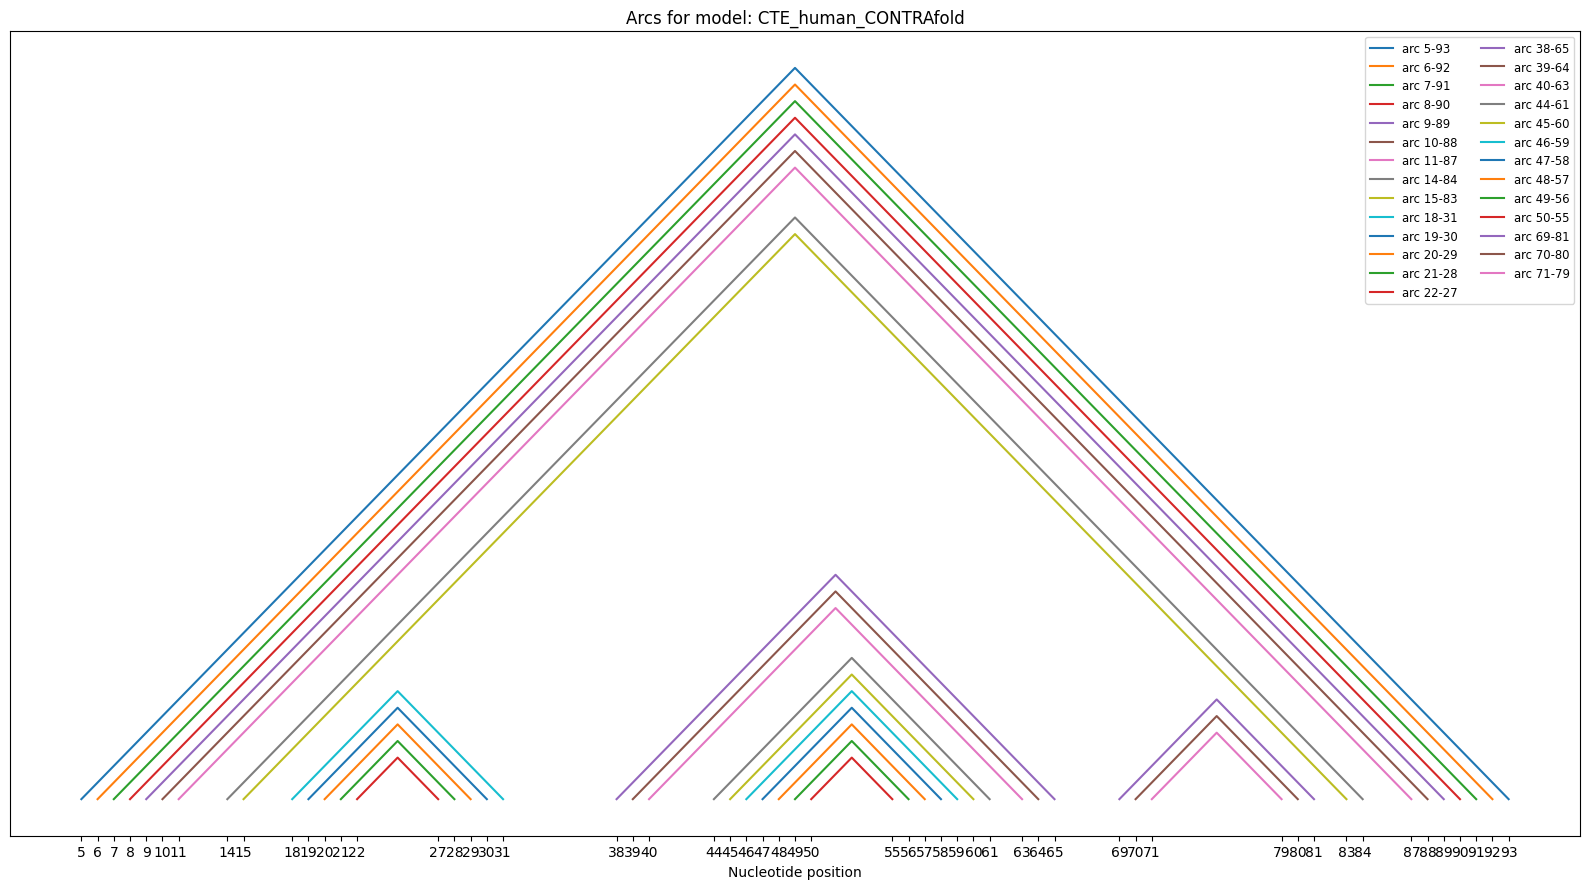

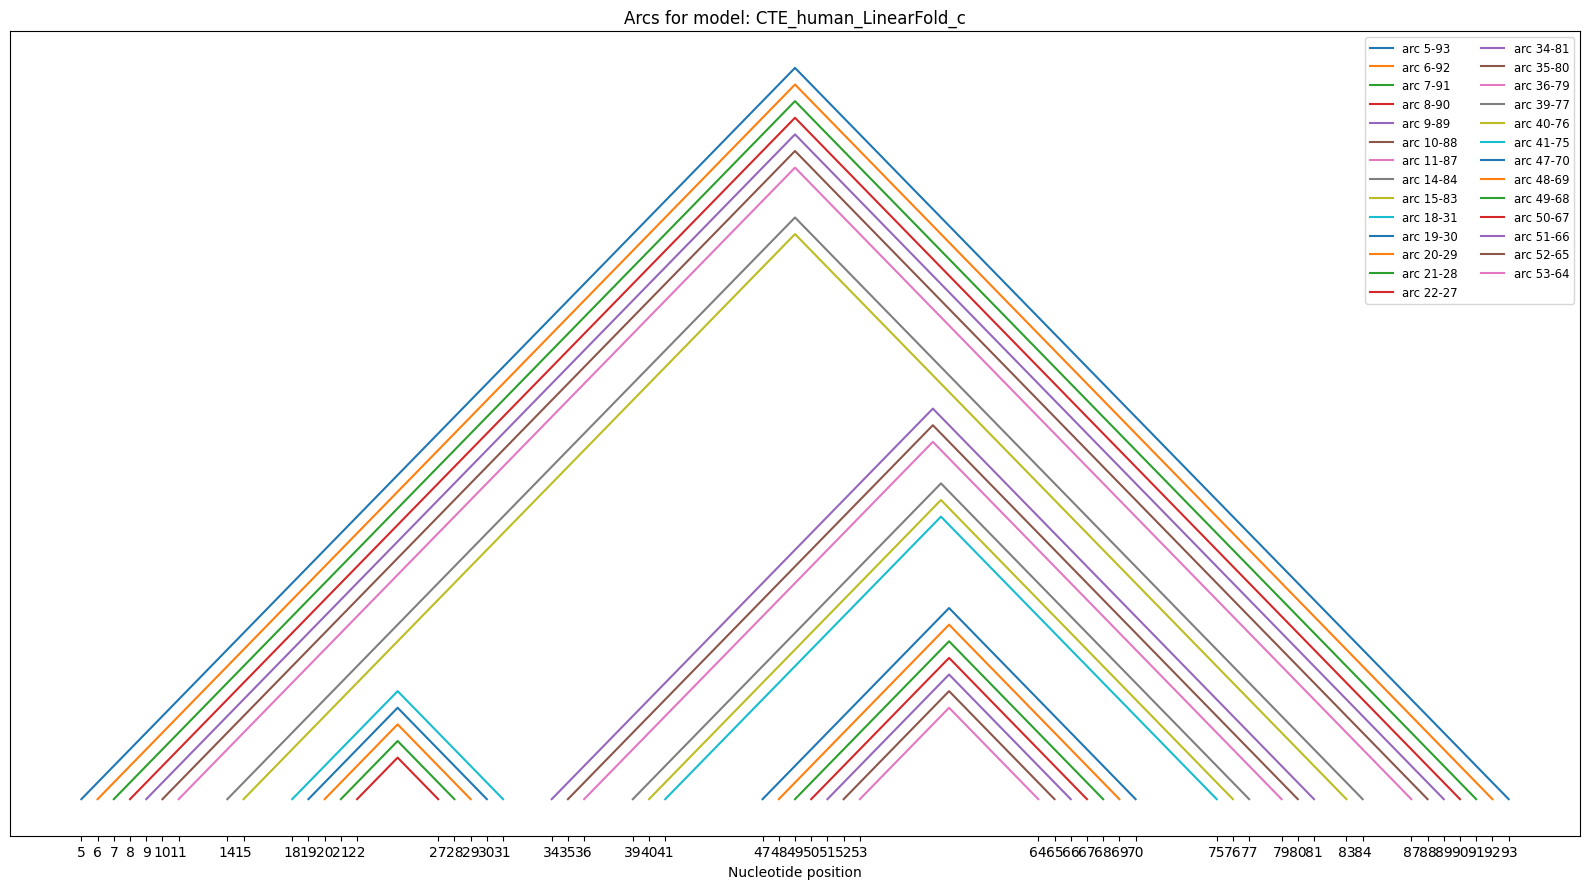

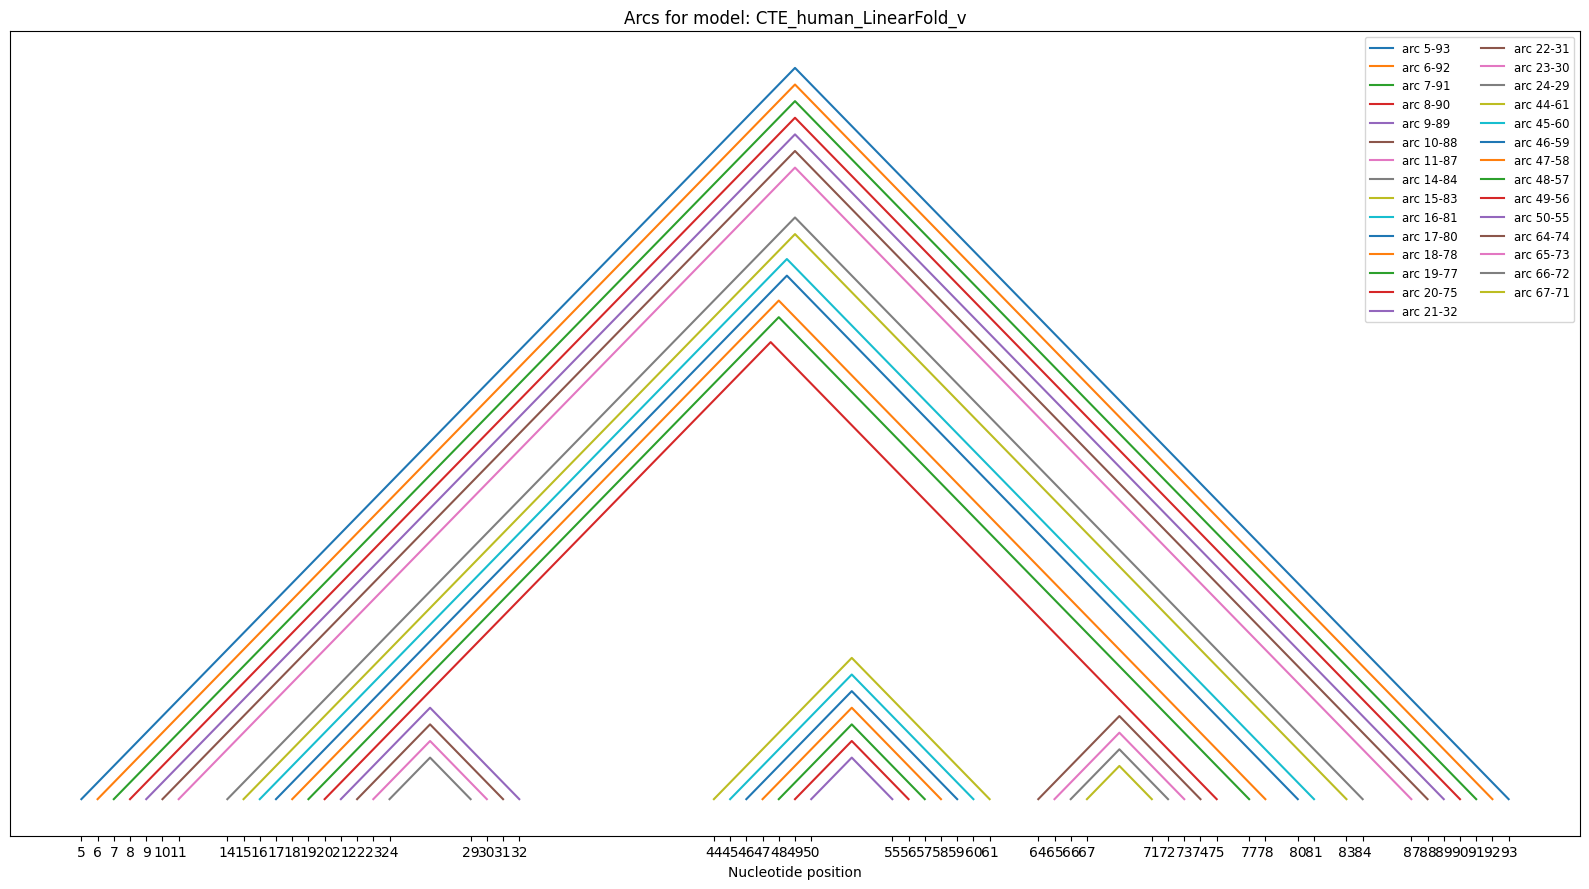

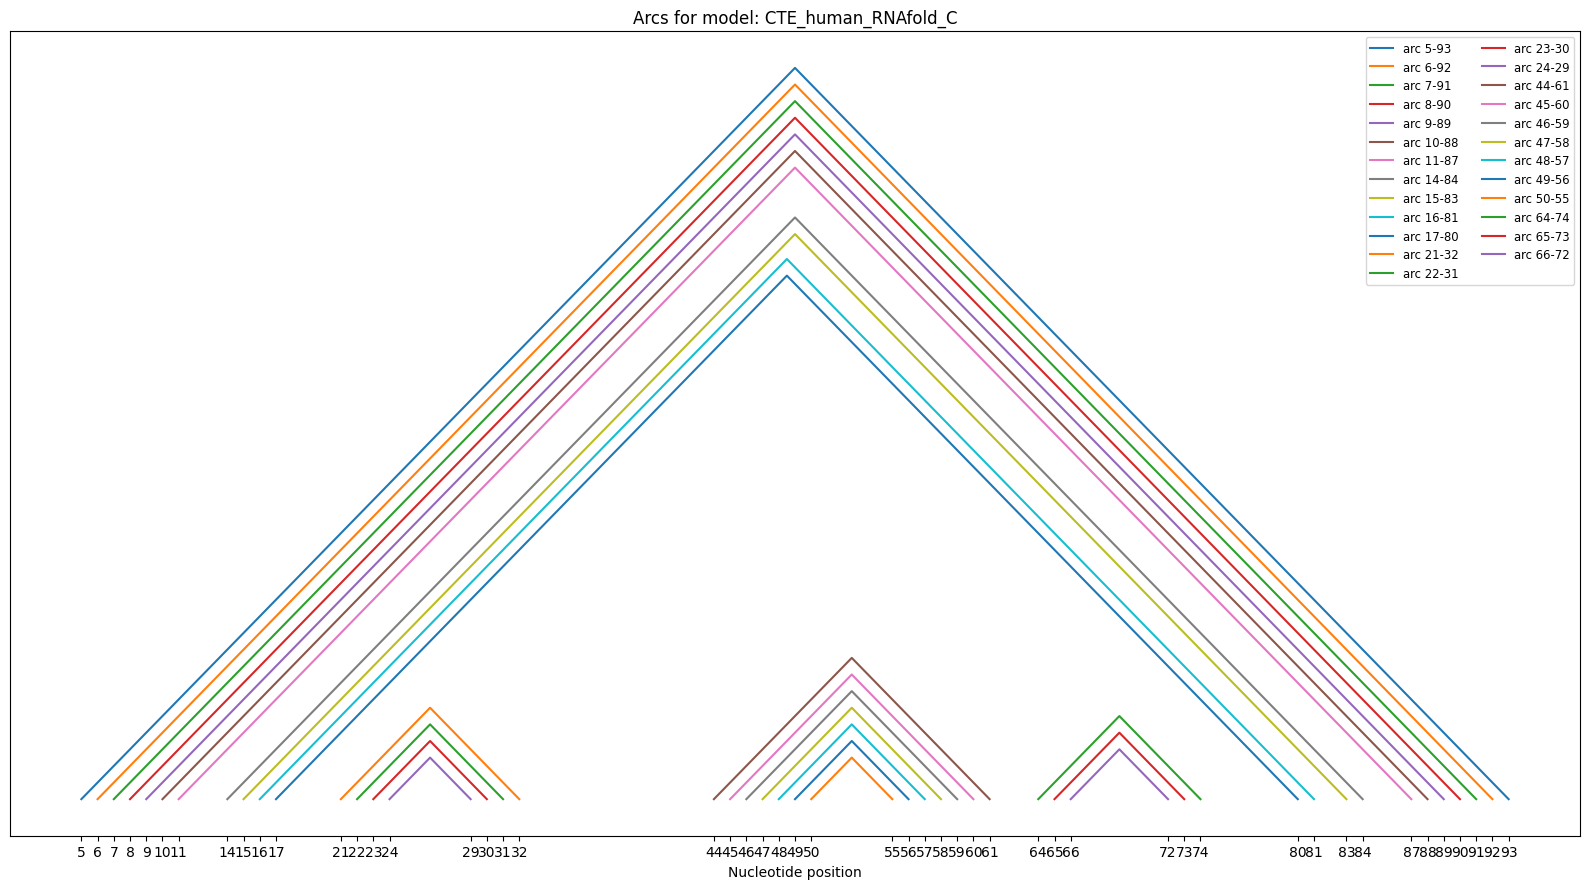

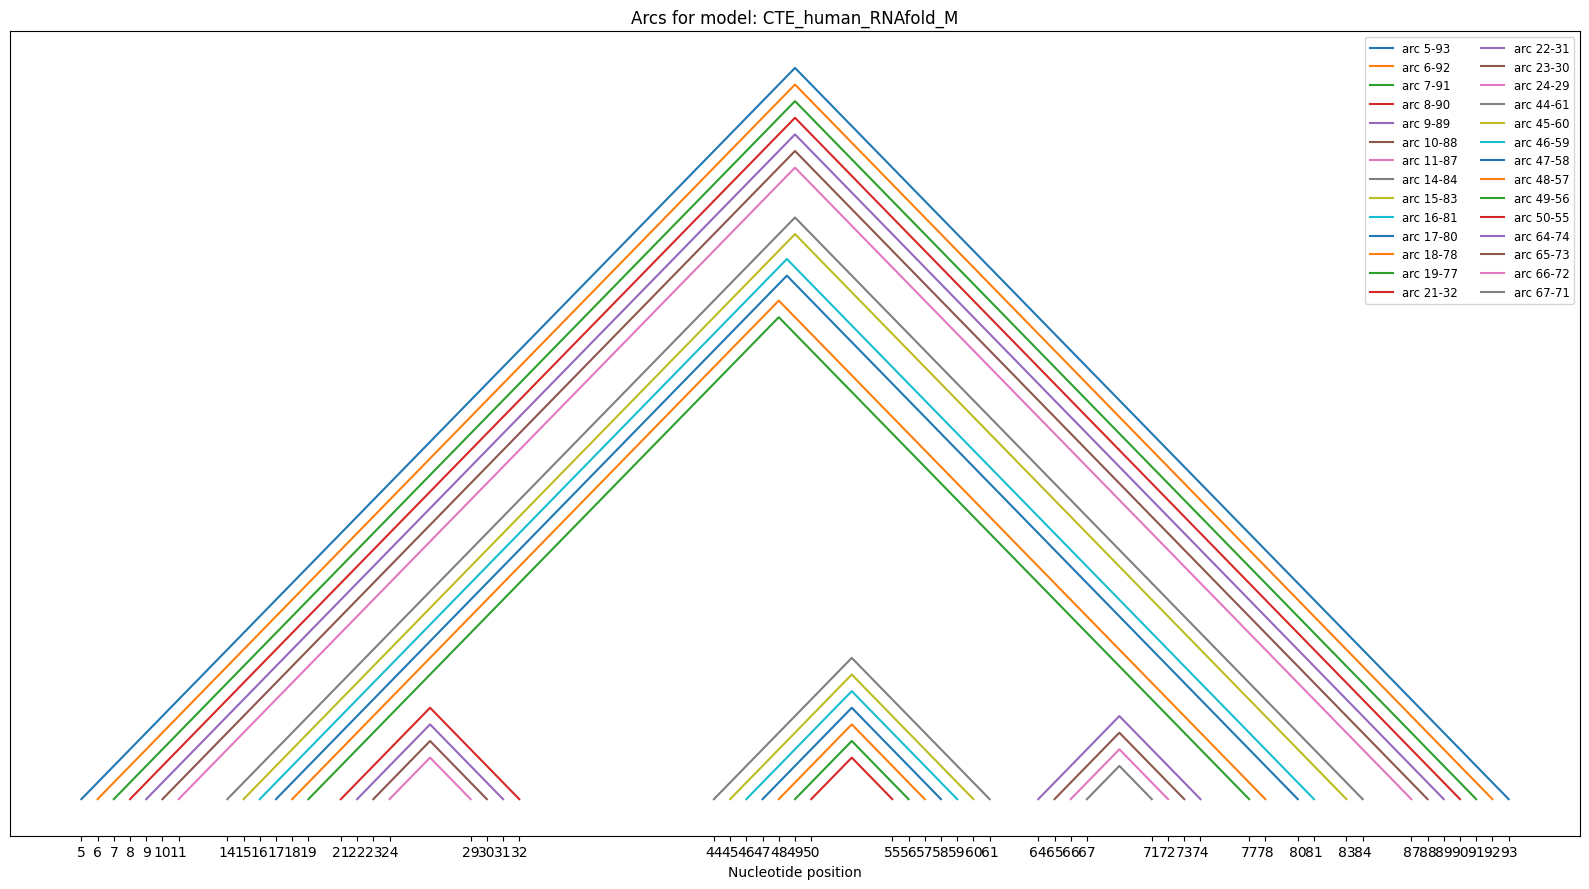

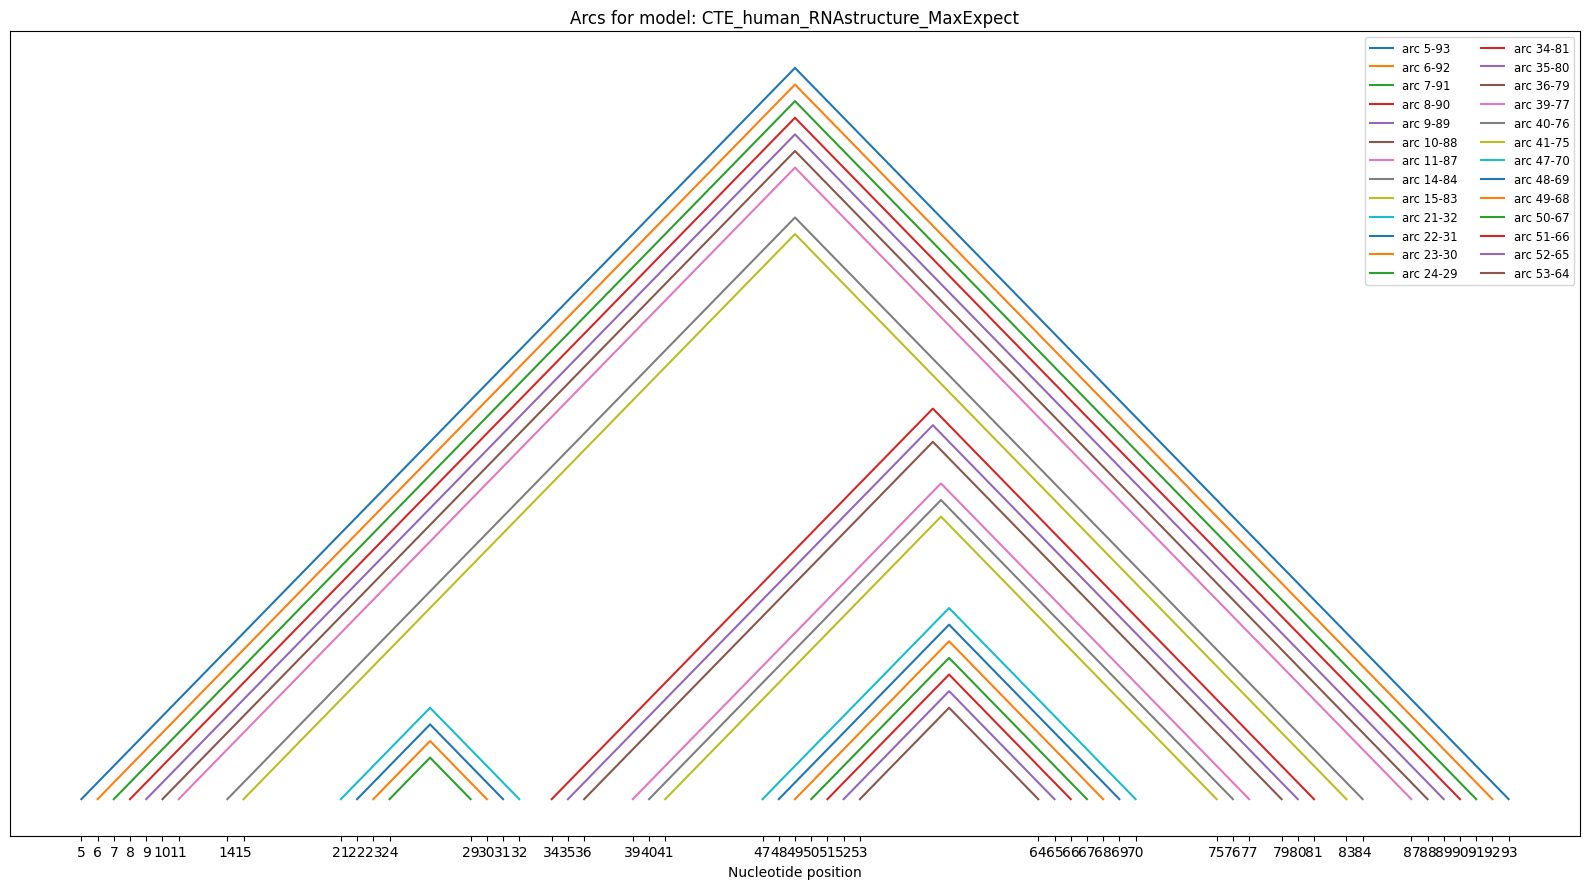

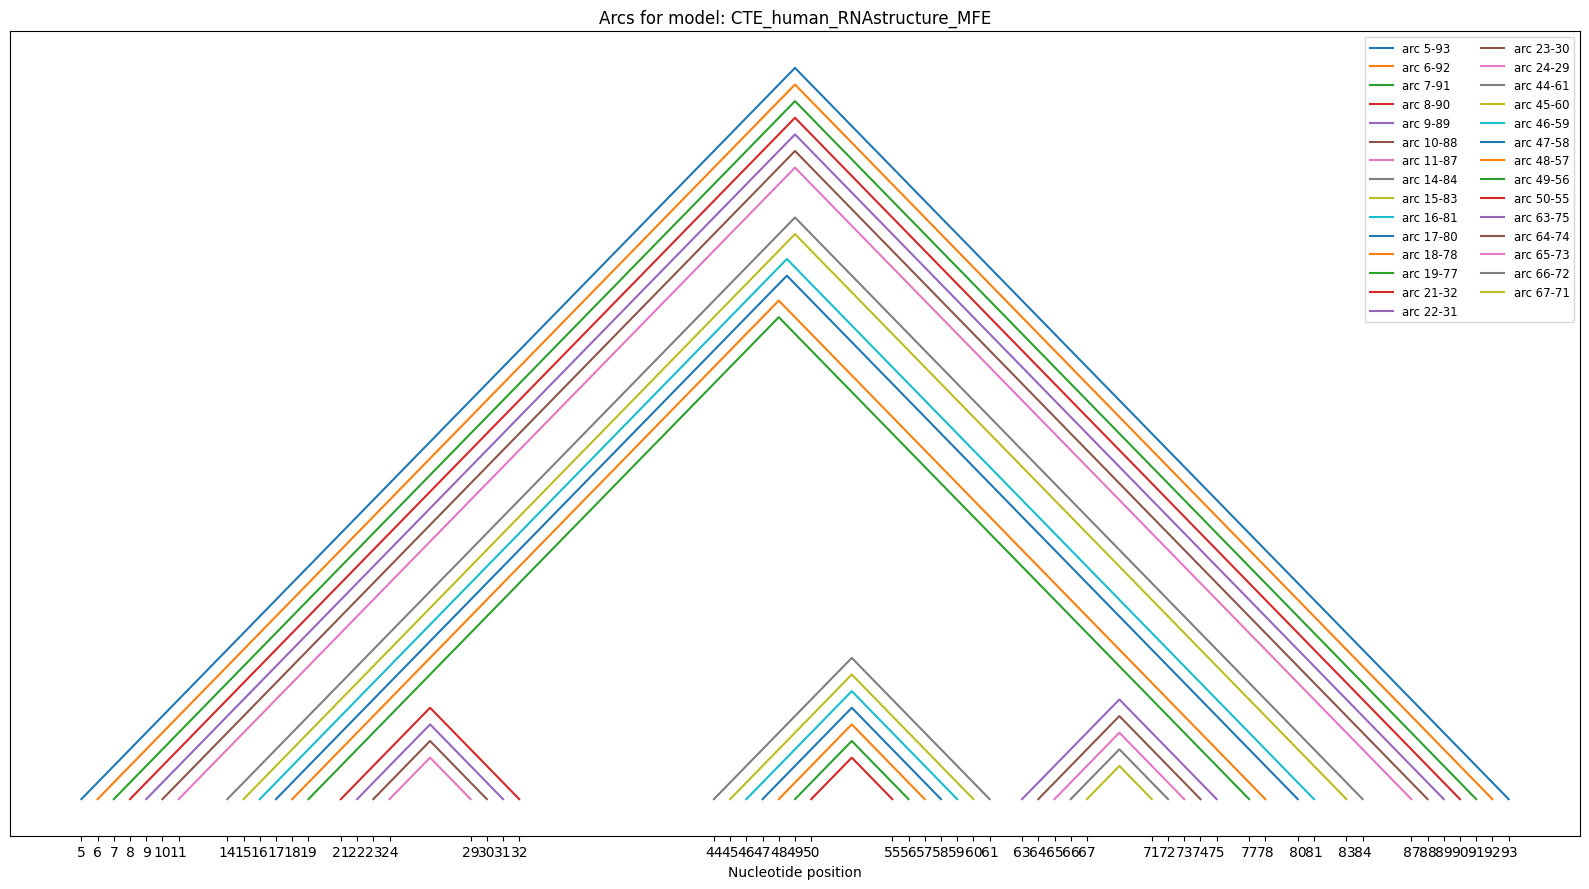

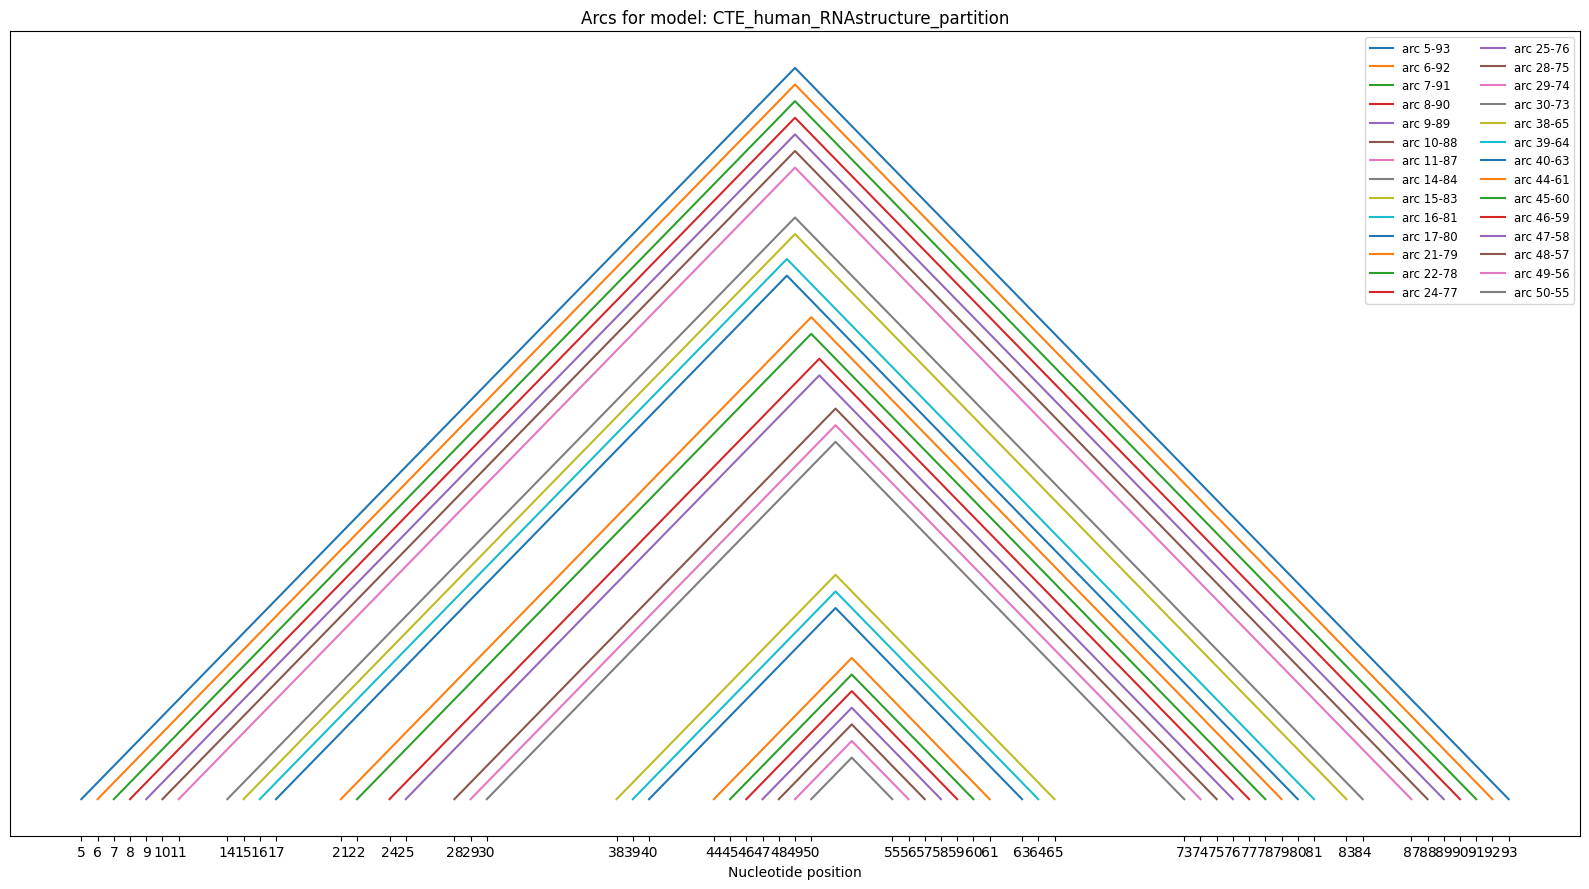

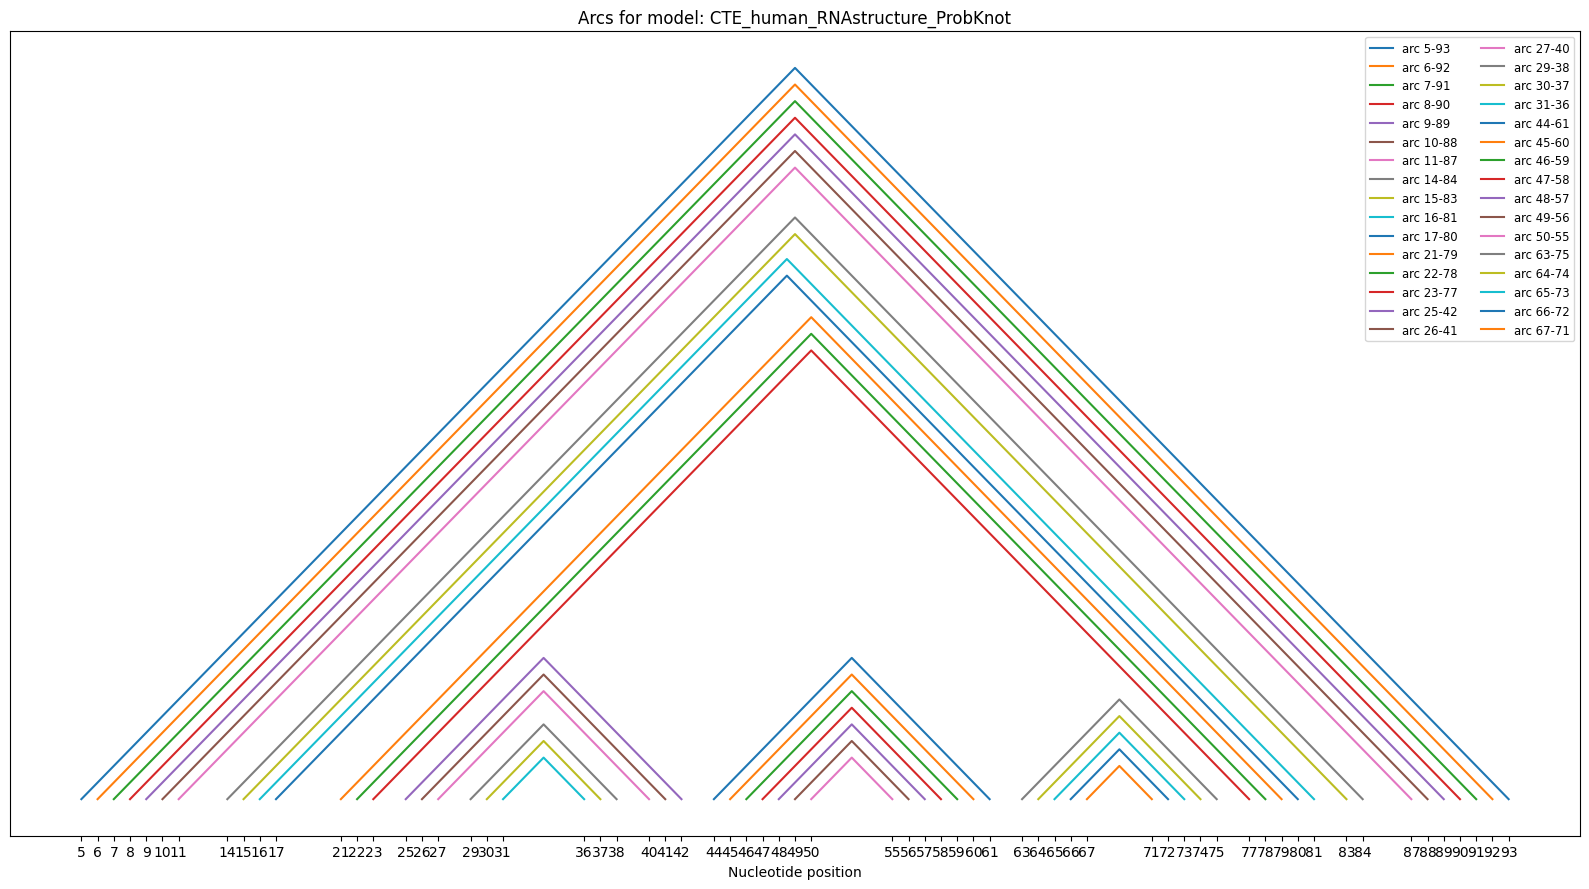

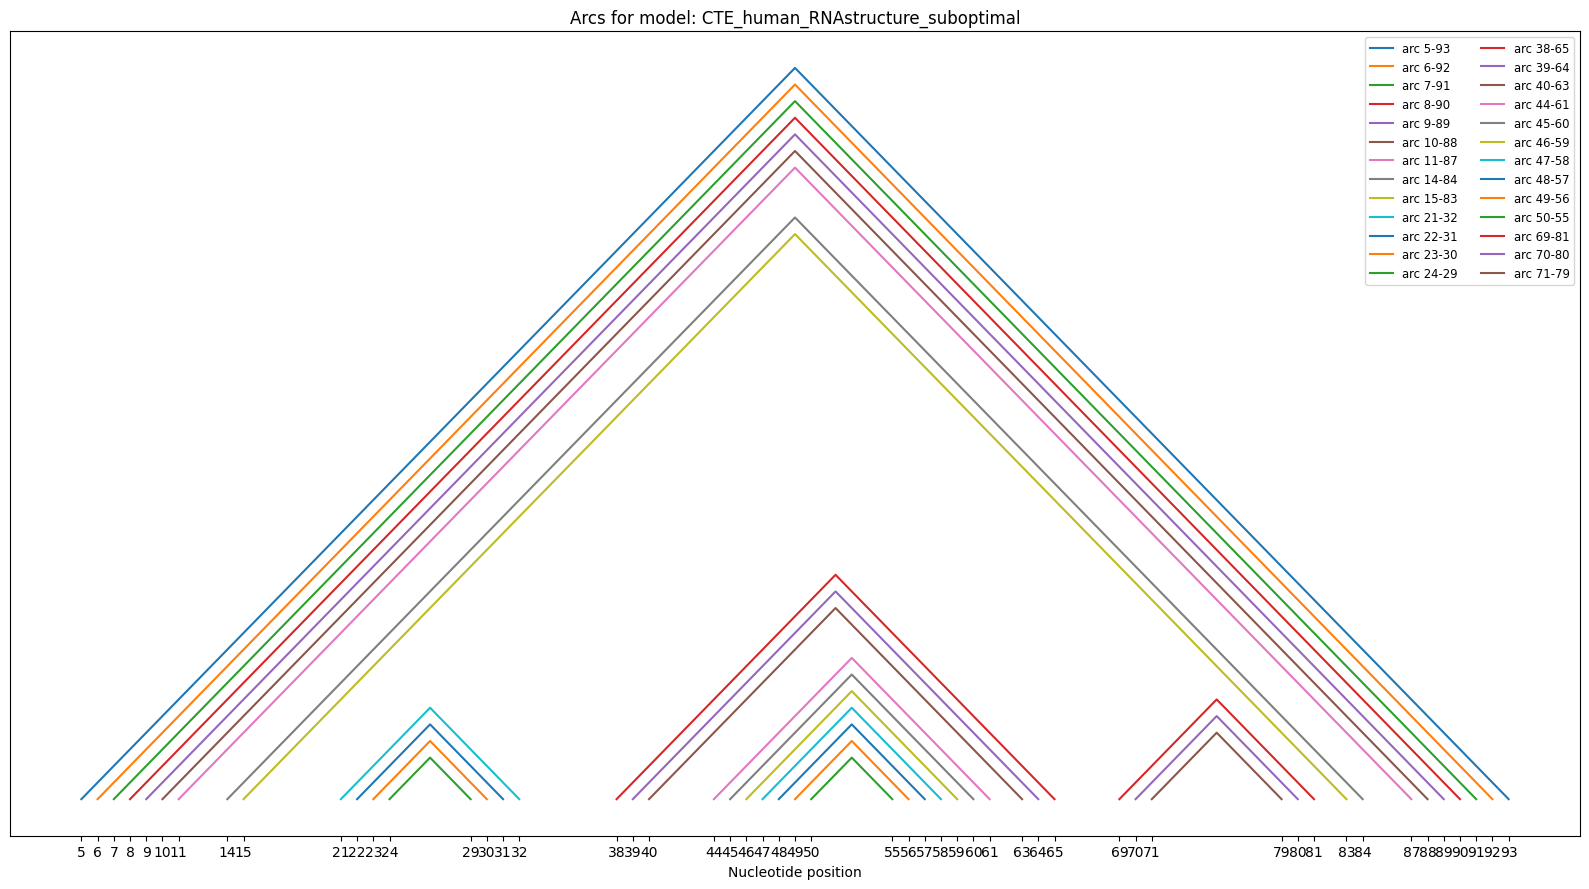

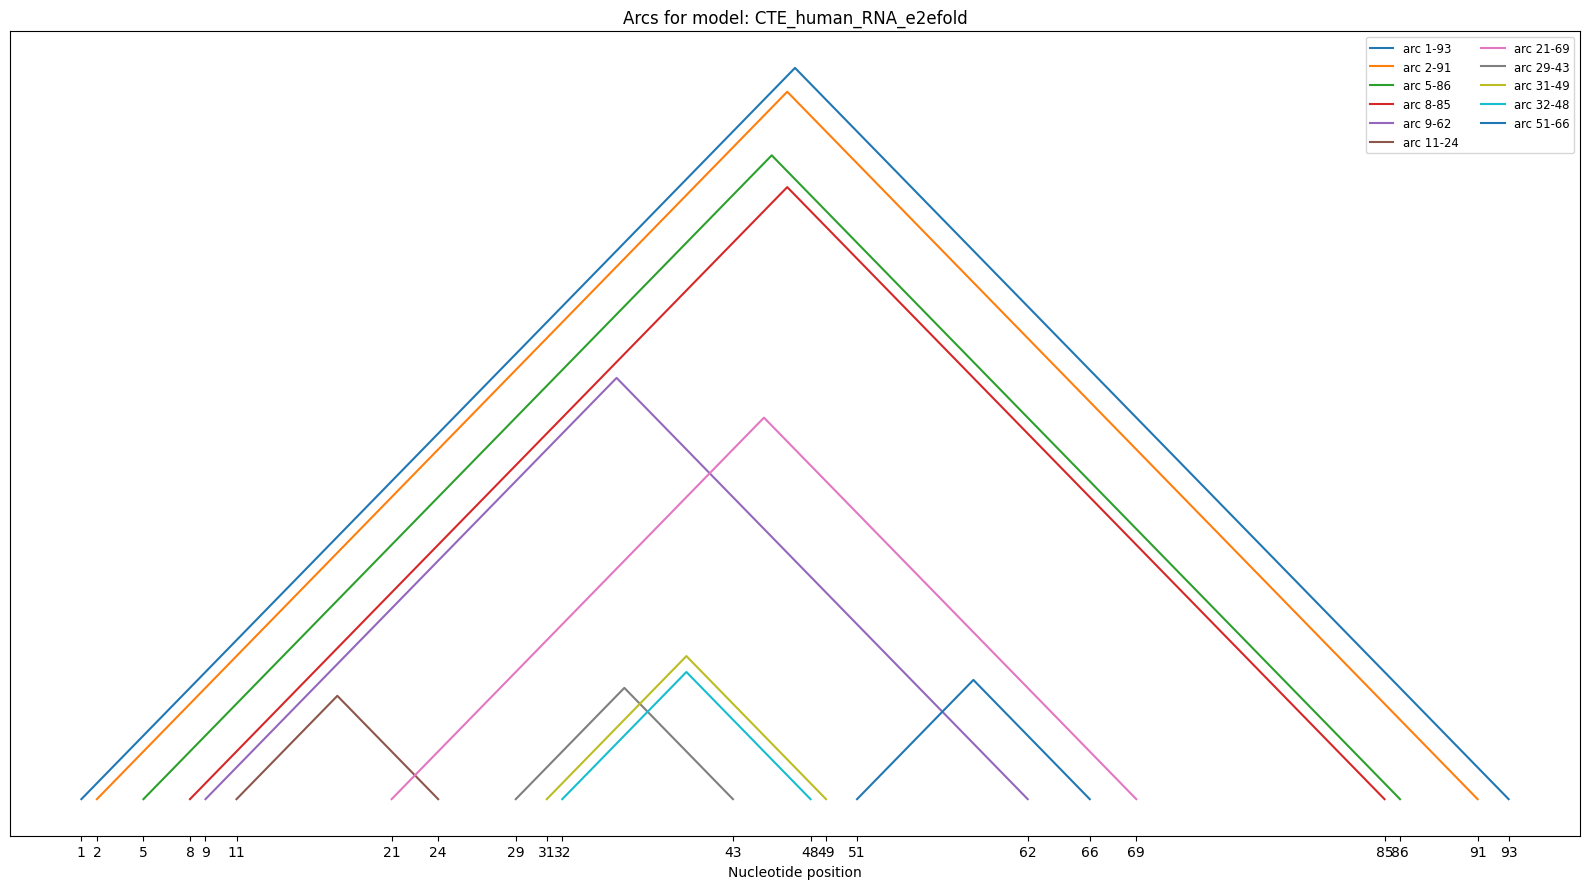

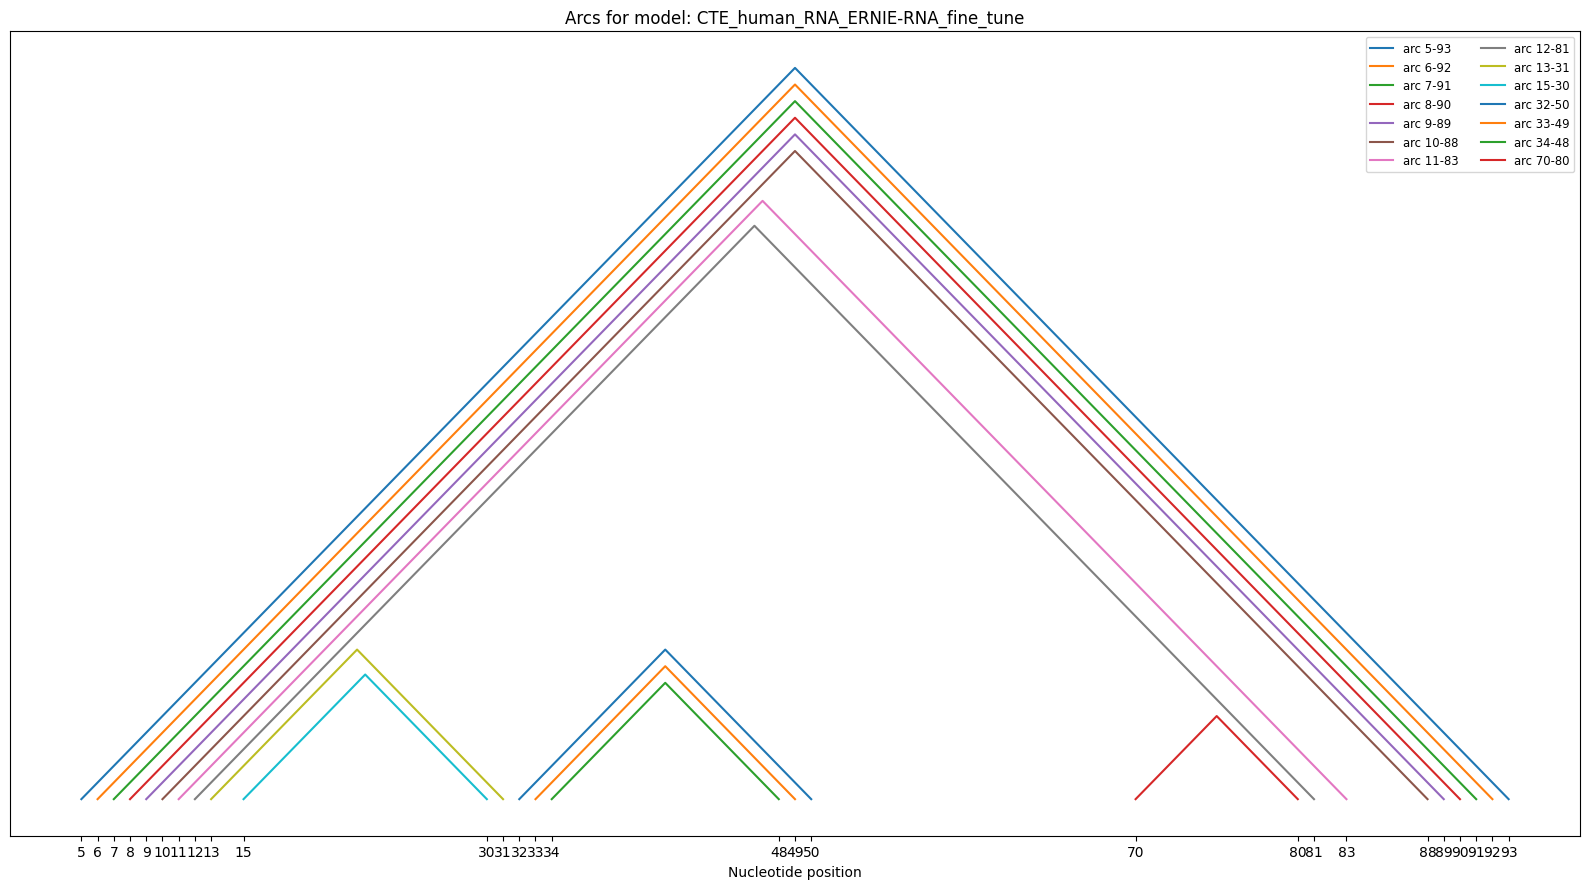

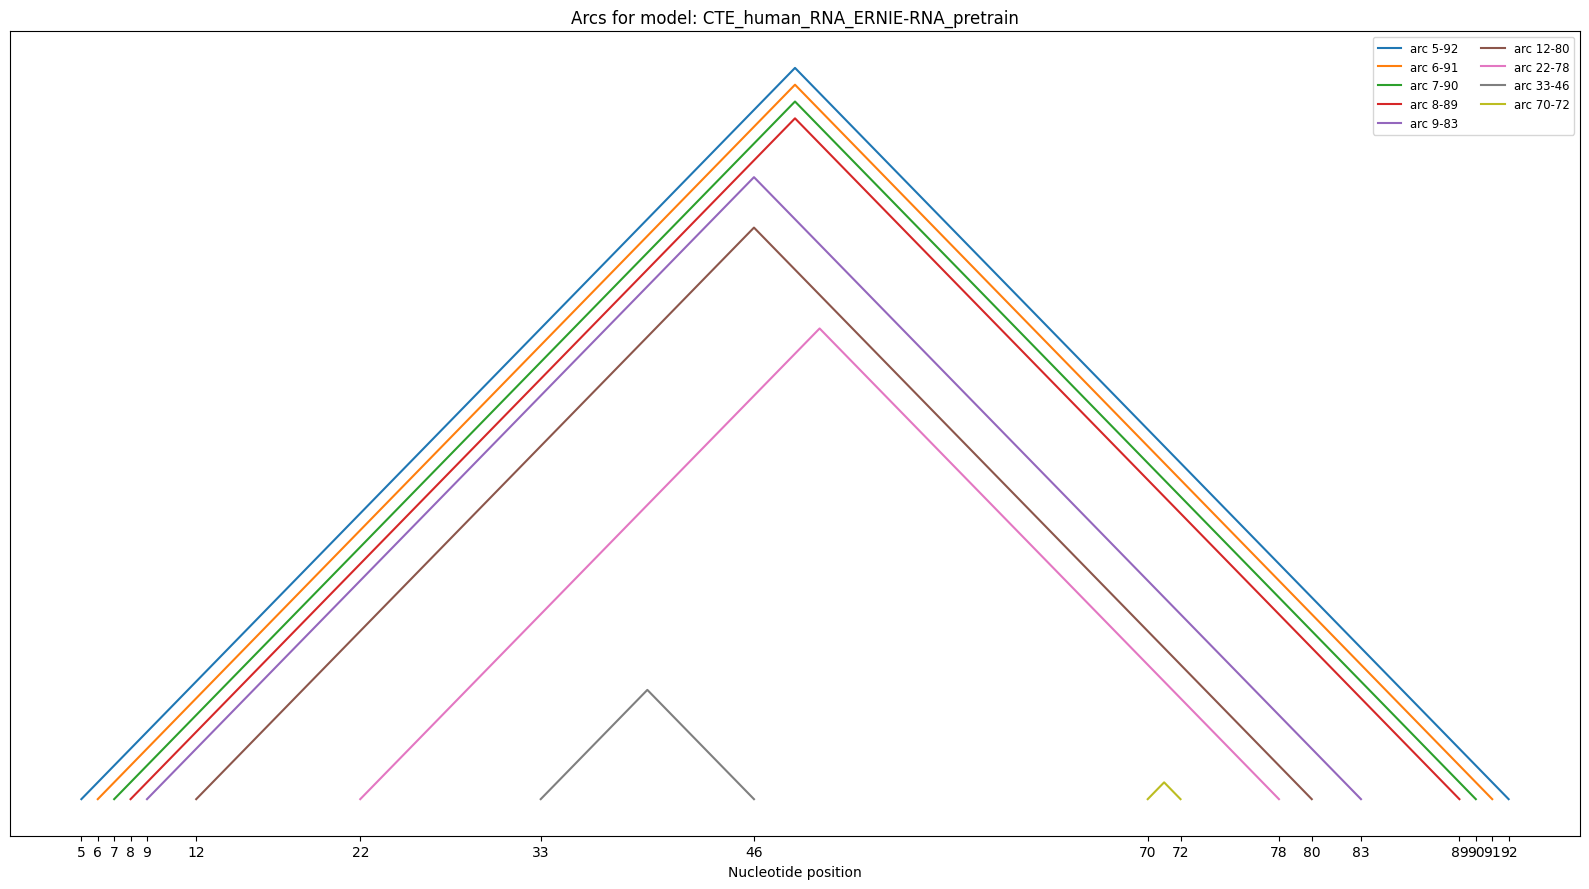

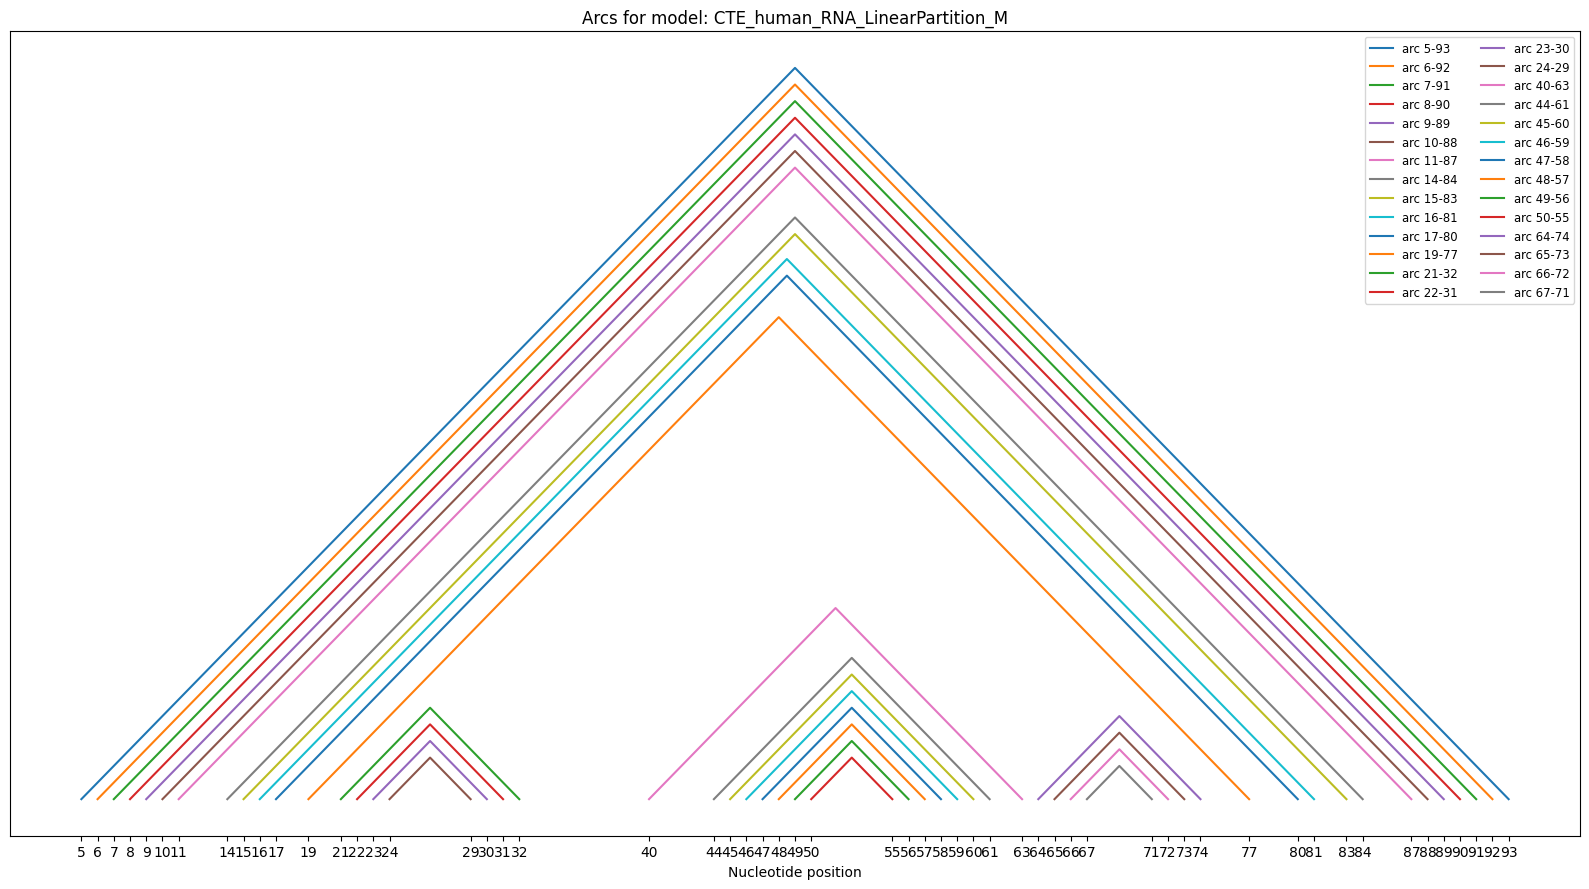

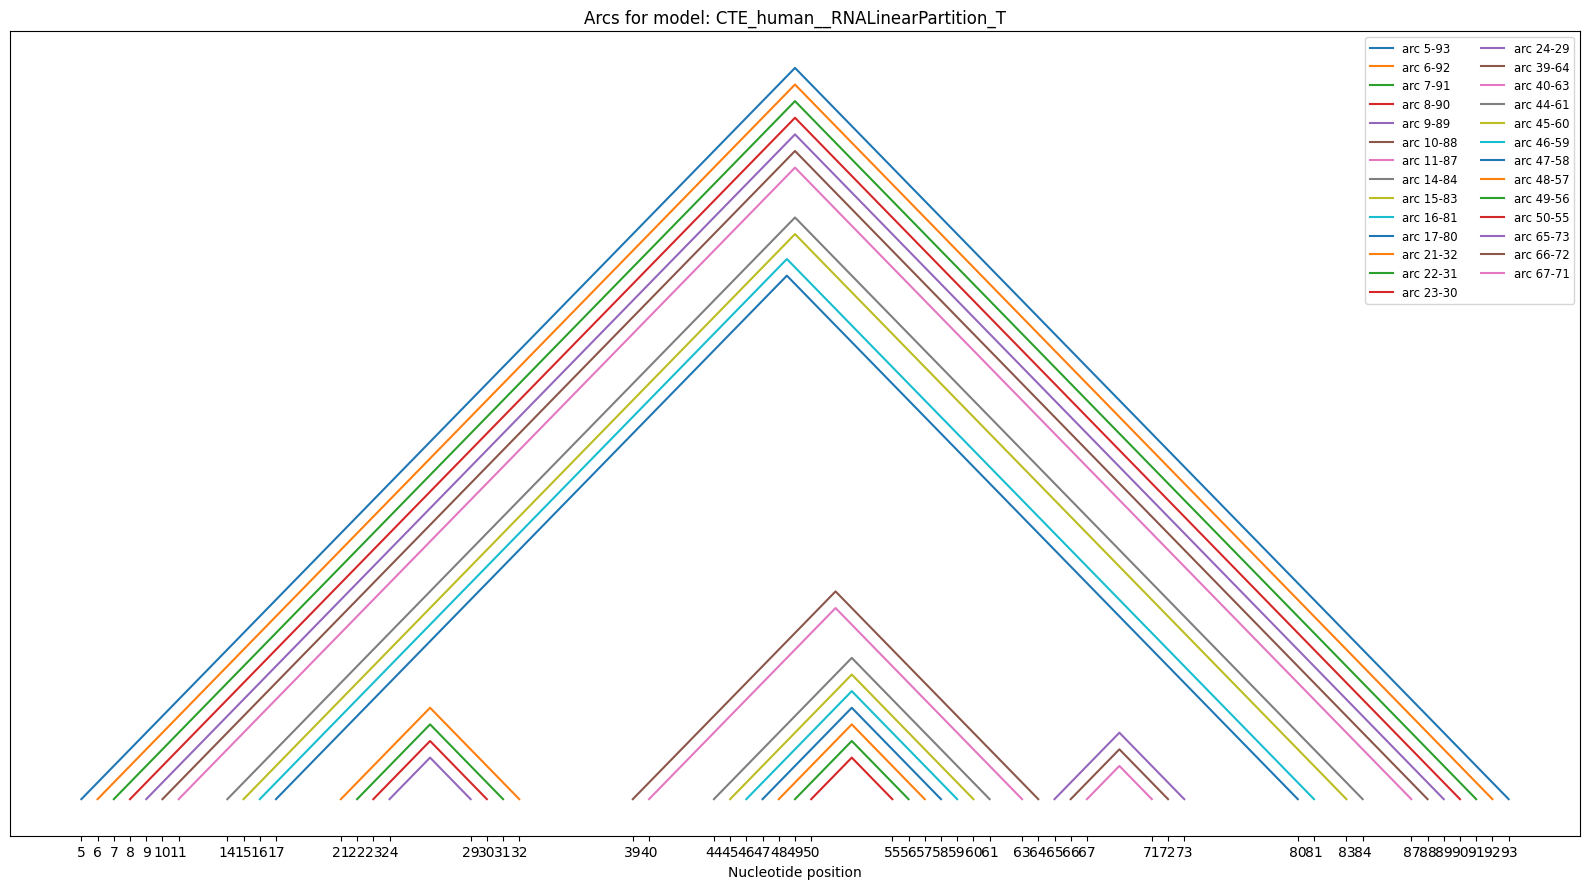

Consensus dot-bracket notation:
ACAAACCGGGGCCACCUACCGACCAAUCGGUCUCUGCCCAUUCUAAGGAGUCCCUUCCUUGUUGGAUUCUGUCCGUGUCAGCGUCUCCCCGGU
....(((((((..((((...((((....))))...........(((((((....)))))))..................)).))..)))))))


In [39]:
def plot_arcs(pairs, ax, title):
    for i, j in pairs.items():
        if j > i:
            ax.plot([i, (i+j)/2, j], [0, (j-i)/2, 0])
    ax.set_title(title)
    ax.axis('off')

all_structs = {'Consensus': consensus, **models}
n = len(all_structs)
cols = 3
rows = int(np.ceil(n/cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
axes = axes.flatten()
for ax, (name, part) in zip(axes, all_structs.items()):
    plot_arcs(part, ax, name)
for ax in axes[n:]:
    ax.axis('off')
plt.tight_layout()
plt.show()


# 8. Визуализация каждой арки отдельно
for name, part in models.items():
    fig, ax = plt.subplots(figsize=(16, 9))
    paired_positions = []
    for i, j in part.items():
        if j > i:
            x = [i, (i+j)/2, j]
            y = [0, (j-i)/2, 0]
            ax.plot(x, y, label=f'arc {i}-{j}')
            paired_positions.extend([i, j])
    ticks = sorted(set(paired_positions))
    ax.set_xticks(ticks)
    ax.set_xlabel('Nucleotide position')
    ax.get_yaxis().set_visible(False)
    ax.set_title(f'Arcs for model: {name}')
    ax.legend(loc='upper right', fontsize='small', ncol=2)
    plt.tight_layout()
    plt.show()

# 9. Dot-bracket
print("Consensus dot-bracket notation:")
print(consensus_seq)
print("".join(dot))

## 9. Логи <a id="logs"></a>
- `tie_log.txt` — ничейные позиции и их распределение партнёров
- `reciprocity_log.txt` — позиции с нарушением взаимности